In [1]:
import os
# Limit threads for OpenBLAS, MKL, and others
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import random
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.preprocessing import StandardScaler

# For all images (bleeding) 

In [13]:
# # Parameters
# real_dir = '/kaggle/input/0-real/0_real/bleeding'
# synthetic_dir = '/kaggle/input/1-synthetic/1_synthetic/bleeding'
# img_size = (224, 224)

# def load_images_from_folder(folder, label):
#     data = []
#     labels = []
#     for file in os.listdir(folder):
#         path = os.path.join(folder, file)
#         try:
#             img = Image.open(path).convert('RGB')
#             img = img.resize(img_size)
#             img = np.asarray(img).flatten()
#             data.append(img)
#             labels.append(label)
#         except:
#             continue
#     return data, labels

# # Load real and synthetic images
# real_data, real_labels = load_images_from_folder(real_dir, label=0)         # 0 = real (blue)
# synthetic_data, synthetic_labels = load_images_from_folder(synthetic_dir, label=1)  # 1 = synthetic (red)

# # Combine
# X = np.array(real_data + synthetic_data)
# y = np.array(real_labels + synthetic_labels)

# # Apply t-SNE
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
# X_tsne = tsne.fit_transform(X)

# # Define color map: 0 = blue (real), 1 = red (synthetic)
# colors = ListedColormap(['blue', 'red'])

# # Plot
# plt.figure(figsize=(10, 7))
# scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=colors, alpha=0.7)
# plt.title("t-SNE: Real (Blue) vs Synthetic (Red) Images")
# # plt.xlabel("t-SNE Component 1")
# # plt.ylabel("t-SNE Component 2")
# handles = [plt.Line2D([0], [0], marker='o', color='w', label='Real', markerfacecolor='blue', markersize=8),
#            plt.Line2D([0], [0], marker='o', color='w', label='Synthetic', markerfacecolor='red', markersize=8)]
# plt.legend(handles=handles)
# plt.grid(True)
# plt.show()

# Randomly selected 400 images (bleeding images)

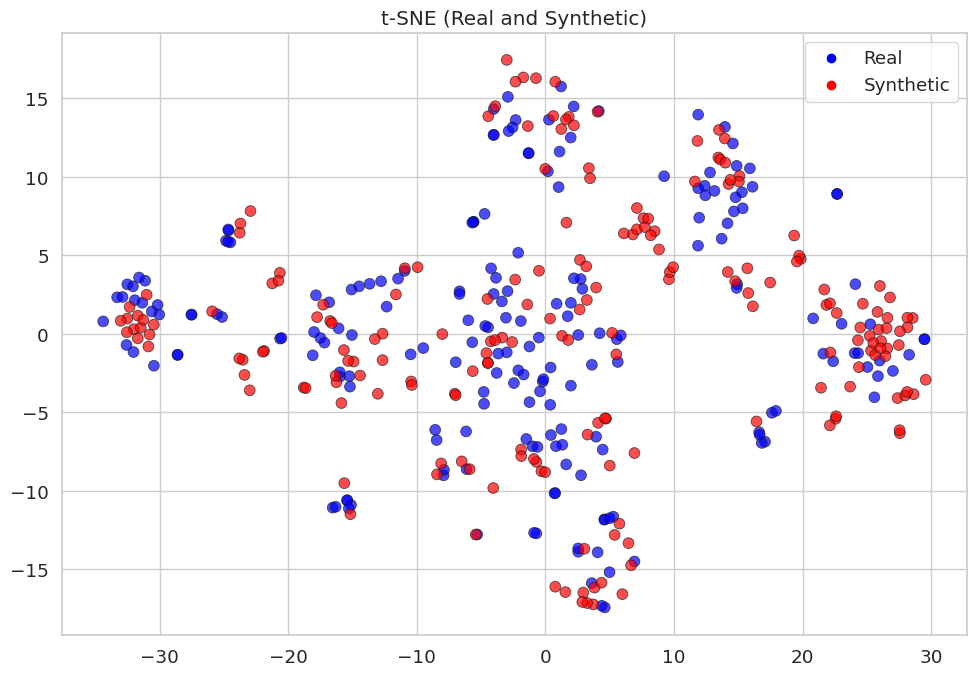

In [15]:
real_dir = '/kaggle/input/0-real/0_real/bleeding'
synthetic_dir = '/kaggle/input/1-synthetic/1_synthetic/bleeding'
img_size = (224, 224)

# Load all image paths
real_paths = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
synthetic_paths = [os.path.join(synthetic_dir, f) for f in os.listdir(synthetic_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Set sample size for each class
num_real_samples = 200
num_synthetic_samples = 200

# Randomly sample once and fix the samples for reproducibility
random.seed(123)
sampled_real = random.sample(real_paths, min(num_real_samples, len(real_paths)))
sampled_synthetic = random.sample(synthetic_paths, min(num_synthetic_samples, len(synthetic_paths)))

# Combine sampled paths with labels
all_paths = [(p, 'Real') for p in sampled_real] + [(p, 'Synthetic') for p in sampled_synthetic]

# Load and process images
data = []
labels = []

for path, label in all_paths:
    try:
        img = Image.open(path).convert('RGB')
        img = img.resize(img_size)
        data.append(np.asarray(img).flatten())
        labels.append(label)
    except Exception as e:
        print(f"Error loading {path}: {e}")
        continue

X = np.array(data)
y = np.array(labels)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=123)
X_tsne = tsne.fit_transform(X)


# Prepare DataFrame for plotting
df = pd.DataFrame({
    'TSNE-1': X_tsne[:, 0],
    'TSNE-2': X_tsne[:, 1],
    'Label': y
})

# Plot
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid", font_scale=1.2)
sns.scatterplot(
    x='TSNE-1', y='TSNE-2',
    hue='Label', palette={'Real': 'blue', 'Synthetic': 'red'},
    data=df, alpha=0.7, s=60, edgecolor='k'
)
plt.title("t-SNE (Real and Synthetic)")
plt.legend()
plt.xlabel("")
plt.ylabel("")
# plt.xlim(-20, 20)
plt.tight_layout()
plt.show()


# Data Augmentation

In [12]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# Paths
input_folder = '/kaggle/input/0-real/0_real/bleeding'
output_folder = 'augmented_images'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Define augmentation generator
datagen = ImageDataGenerator(
    rotation_range=120,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Parameters
img_size = (256, 256)
num_augmented = 12  # number of augmented images per original

# Augment each image
for filename in os.listdir(input_folder):
    path = os.path.join(input_folder, filename)
    try:
        img = load_img(path, target_size=img_size)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)  # shape: (1, height, width, channels)

        # Generate and save images
        prefix = os.path.splitext(filename)[0]
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_folder,
                                  save_prefix=prefix, save_format='jpg'):
            i += 1
            if i >= num_augmented:
                break
    except:
        print(f"Failed to process: {filename}")

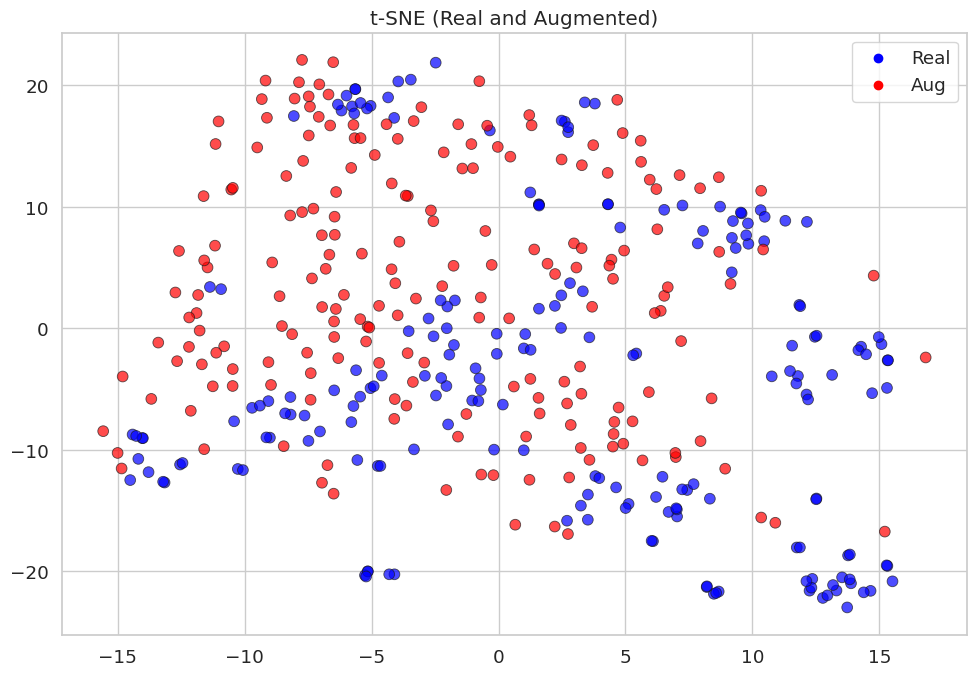

In [14]:
synthetic_dir = '/kaggle/working/augmented_images'
img_size = (224, 224)

# Load synthetic image paths
synthetic_paths = [os.path.join(synthetic_dir, f) for f in os.listdir(synthetic_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Sample only synthetic images randomly (e.g., 400)
num_synthetic_samples = 200
random.seed(123)
sampled_synthetic = random.sample(synthetic_paths, min(num_synthetic_samples, len(synthetic_paths)))


# Combine sampled paths with labels
all_paths = [(p, 'Real') for p in sampled_real] + [(p, 'Aug') for p in sampled_synthetic]


# Load and process images
data = []
labels = []

for path, label in all_paths:
    try:
        img = Image.open(path).convert('RGB')
        img = img.resize(img_size)
        data.append(np.asarray(img).flatten())
        labels.append(label)
    except Exception as e:
        print(f"Failed loading image {path}: {e}")
        continue

X = np.array(data)
y = np.array(labels)

# t-SNE embedding
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=123)
X_tsne = tsne.fit_transform(X)

# Prepare DataFrame for seaborn plotting
df = pd.DataFrame({
    'TSNE-1': X_tsne[:, 0],
    'TSNE-2': X_tsne[:, 1],
    'Label': y
})

# Plot with seaborn
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid", font_scale=1.2)
sns.scatterplot(
    x='TSNE-1', y='TSNE-2',
    hue='Label', palette={'Real': 'blue', 'Aug': 'red'},
    data=df, alpha=0.7, s=60, edgecolor='k'
)
plt.legend()
plt.title("t-SNE (Real and Augmented)")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()


# Paper: 
*Colonoscopic image synthesis with generative adversarial network for enhanced detection of sessile serrated lesions using convolutional neural network*


In [6]:
import os
import random
from PIL import Image
import numpy as np

# Settings
input_dir = '/kaggle/input/0-real/0_real/bleeding'
output_base = 'paper_augmented_images'
rotation_ranges = [(0, 120), (120, 240), (240, 360)]
crop_size = (256, 256)
aug_per_image = 12

# Create output base directory
os.makedirs(output_base, exist_ok=True)

# Helper: crop function (random crop of specified size)
def random_crop(img, size):
    w, h = img.size
    crop_w, crop_h = size
    if w < crop_w or h < crop_h:
        return None
    x = random.randint(0, w - crop_w)
    y = random.randint(0, h - crop_h)
    return img.crop((x, y, x + crop_w, y + crop_h))

# Augmentation loop
augmented_images = []
skipped_count = 0

for img_name in os.listdir(input_dir):
    img_path = os.path.join(input_dir, img_name)
    try:
        orig = Image.open(img_path).convert('RGB')
        flipped = orig.transpose(Image.FLIP_TOP_BOTTOM)

        versions = [orig, flipped]
        for base in versions:
            for r_start, r_end in rotation_ranges:
                angle = random.uniform(r_start, r_end)
                rotated = base.rotate(angle)

                for i in range(2):  # 2 random crops
                    cropped = random_crop(rotated, crop_size)
                    if cropped:
                        augmented_images.append(cropped)
                    else:
                        skipped_count += 1

    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        continue

print(f"✅ Augmentation complete: {len(augmented_images)} images created")
print(f"⚠️ Skipped crops due to size issues: {skipped_count}")

# Save sampled subsets
sizes = {'T-aug1': 1200, 'T-aug2': 1800, 'T-aug3': 2400}
random.shuffle(augmented_images)

for name, count in sizes.items():
    folder = os.path.join(output_base, name)
    os.makedirs(folder, exist_ok=True)
    for i, img in enumerate(augmented_images[:count]):
        img.save(os.path.join(folder, f'{name}_{i+1}.jpg'))
    print(f"✅ Saved {count} images to {name}")


✅ Augmentation complete: 12564 images created
⚠️ Skipped crops due to size issues: 0
✅ Saved 1200 images to T-aug1
✅ Saved 1800 images to T-aug2
✅ Saved 2400 images to T-aug3


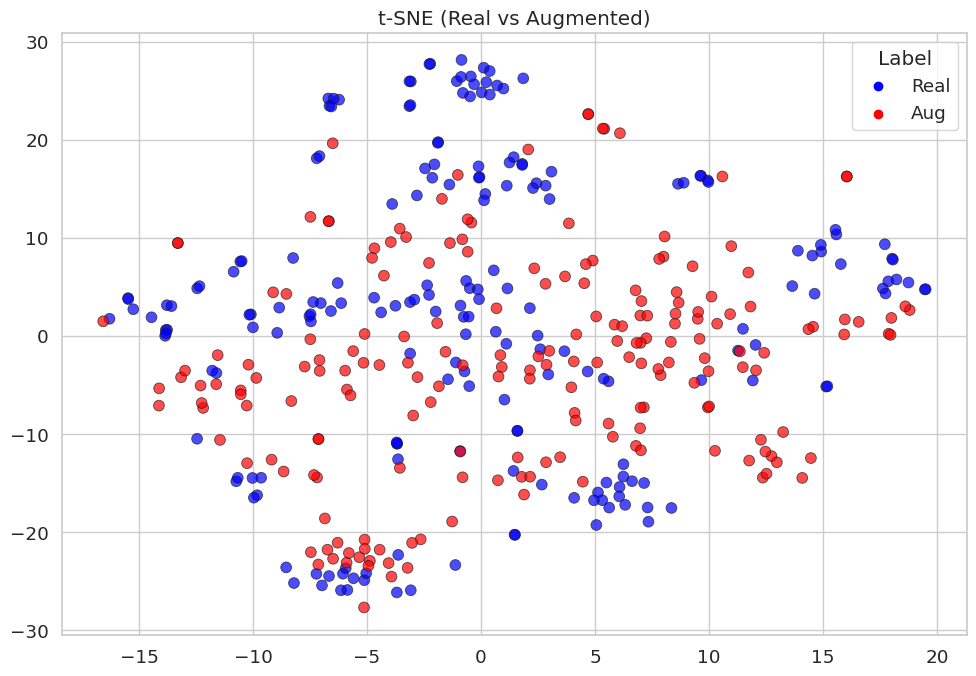

In [11]:
synthetic_dir = '/kaggle/working/paper_augmented_images/T-aug3'
img_size = (224, 224)

# Load synthetic image paths
synthetic_paths = [os.path.join(synthetic_dir, f) for f in os.listdir(synthetic_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Sample only synthetic images randomly (e.g., 400)
num_synthetic_samples = 200
random.seed(42)
sampled_synthetic = random.sample(synthetic_paths, min(num_synthetic_samples, len(synthetic_paths)))


# Combine sampled paths with labels
all_paths = [(p, 'Real') for p in sampled_real] + [(p, 'Aug') for p in sampled_synthetic]


# Load and process images
data = []
labels = []

for path, label in all_paths:
    try:
        img = Image.open(path).convert('RGB')
        img = img.resize(img_size)
        data.append(np.asarray(img).flatten())
        labels.append(label)
    except Exception as e:
        print(f"Failed loading image {path}: {e}")
        continue

X = np.array(data)
y = np.array(labels)

# t-SNE embedding
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

# Prepare DataFrame for seaborn plotting
df = pd.DataFrame({
    'TSNE-1': X_tsne[:, 0],
    'TSNE-2': X_tsne[:, 1],
    'Label': y
})

# Plot with seaborn
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid", font_scale=1.2)
sns.scatterplot(
    x='TSNE-1', y='TSNE-2',
    hue='Label', palette={'Real': 'blue', 'Aug': 'red'},
    data=df, alpha=0.7, s=60, edgecolor='k'
)
plt.title("t-SNE (Real vs Augmented)")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()


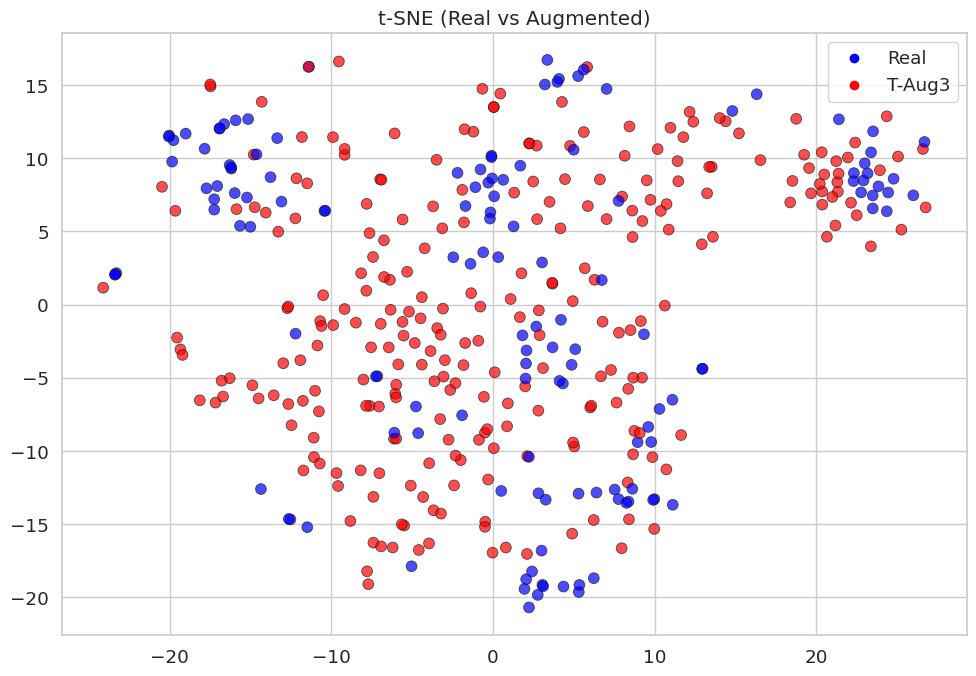

In [8]:
real_dir = '/kaggle/input/0-real/0_real/bleeding'
synthetic_dir = '/kaggle/working/paper_augmented_images/T-aug3'
img_size = (224, 224)
total_samples = 400

# Load and label all image paths
# real_paths = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
synthetic_paths = [os.path.join(synthetic_dir, f) for f in os.listdir(synthetic_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Combine and label
all_paths = [(p, 'Real') for p in real_paths] + [(p, 'T-Aug3') for p in synthetic_paths]

# Randomly sample 200
sampled = random.sample(all_paths, min(total_samples, len(all_paths)))

# Load and process images
data = []
labels = []

for path, label in sampled:
    try:
        img = Image.open(path).convert('RGB')
        img = img.resize(img_size)
        data.append(np.asarray(img).flatten())
        labels.append(label)
    except:
        continue

X = np.array(data)
y = np.array(labels)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

# DataFrame for seaborn
df = pd.DataFrame()
df['TSNE-1'] = X_tsne[:, 0]
df['TSNE-2'] = X_tsne[:, 1]
df['Label'] = y

# Plot with seaborn
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid", font_scale=1.2)
sns.scatterplot(
    x='TSNE-1', y='TSNE-2', hue='Label', palette={'Real': 'blue', 'T-Aug3': 'red'},
    data=df, alpha=0.7, s=60, edgecolor='k'
)

plt.title("t-SNE (Real vs Augmented)")
plt.legend()
plt.xlabel("")   # Remove x-axis label
plt.ylabel("")   # Remove y-axis label
plt.tight_layout()
plt.show()

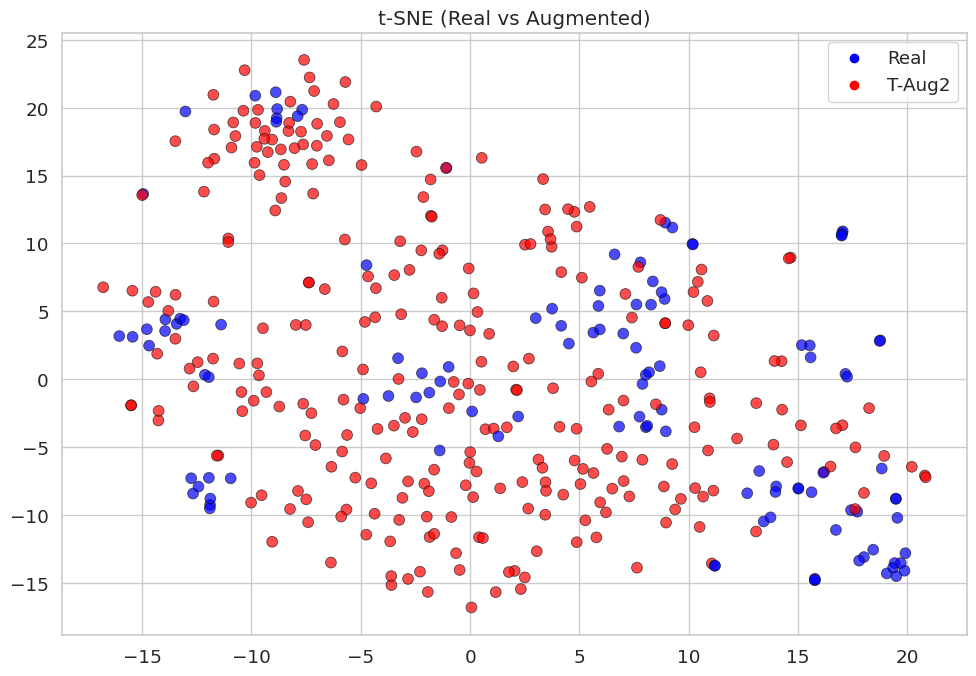

In [9]:
real_dir = '/kaggle/input/0-real/0_real/bleeding'
synthetic_dir = '/kaggle/working/paper_augmented_images/T-aug3'
img_size = (224, 224)
total_samples = 400

# Load and label all image paths
real_paths = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
synthetic_paths = [os.path.join(synthetic_dir, f) for f in os.listdir(synthetic_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Combine and label
all_paths = [(p, 'Real') for p in real_paths] + [(p, 'T-Aug2') for p in synthetic_paths]

# Randomly sample 200
sampled = random.sample(all_paths, min(total_samples, len(all_paths)))

# Load and process images
data = []
labels = []

for path, label in sampled:
    try:
        img = Image.open(path).convert('RGB')
        img = img.resize(img_size)
        data.append(np.asarray(img).flatten())
        labels.append(label)
    except:
        continue

X = np.array(data)
y = np.array(labels)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

# DataFrame for seaborn
df = pd.DataFrame()
df['TSNE-1'] = X_tsne[:, 0]
df['TSNE-2'] = X_tsne[:, 1]
df['Label'] = y

# Plot with seaborn
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid", font_scale=1.2)
sns.scatterplot(
    x='TSNE-1', y='TSNE-2', hue='Label', palette={'Real': 'blue', 'T-Aug2': 'red'},
    data=df, alpha=0.7, s=60, edgecolor='k'
)
plt.title("t-SNE (Real vs Augmented)")
plt.legend()
plt.xlabel("")   # Remove x-axis label
plt.ylabel("")   # Remove y-axis label
plt.tight_layout()
plt.show()

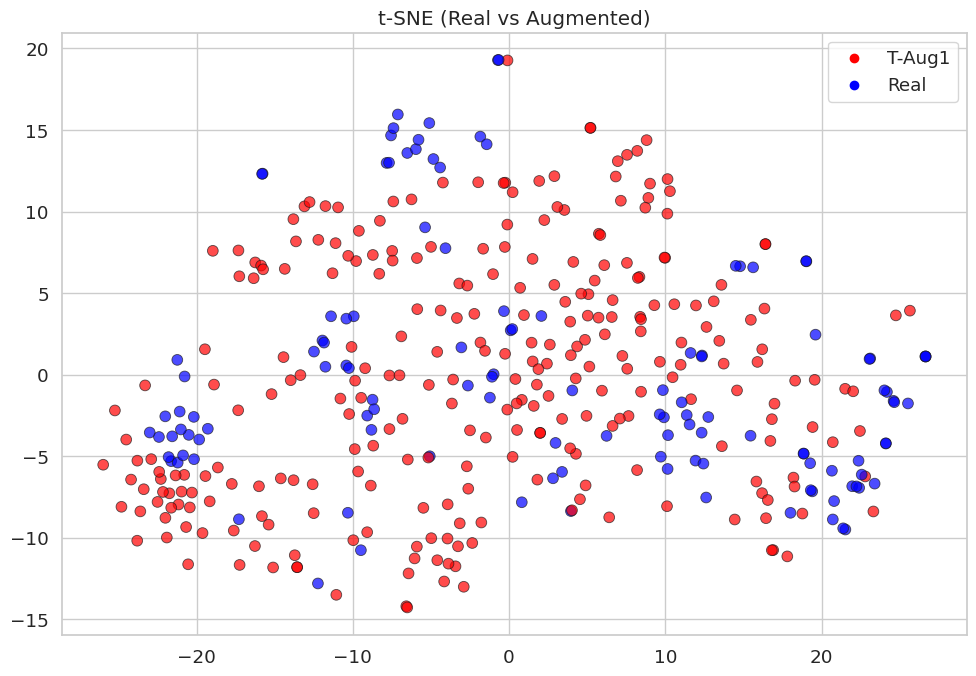

In [10]:
real_dir = '/kaggle/input/0-real/0_real/bleeding'
synthetic_dir = '/kaggle/working/paper_augmented_images/T-aug3'
img_size = (224, 224)
total_samples = 400

# Load and label all image paths
real_paths = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
synthetic_paths = [os.path.join(synthetic_dir, f) for f in os.listdir(synthetic_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Combine and label
all_paths = [(p, 'Real') for p in real_paths] + [(p, 'T-Aug1') for p in synthetic_paths]

# Randomly sample 200
sampled = random.sample(all_paths, min(total_samples, len(all_paths)))

# Load and process images
data = []
labels = []

for path, label in sampled:
    try:
        img = Image.open(path).convert('RGB')
        img = img.resize(img_size)
        data.append(np.asarray(img).flatten())
        labels.append(label)
    except:
        continue

X = np.array(data)
y = np.array(labels)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

# DataFrame for seaborn
df = pd.DataFrame()
df['TSNE-1'] = X_tsne[:, 0]
df['TSNE-2'] = X_tsne[:, 1]
df['Label'] = y

# Plot with seaborn
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid", font_scale=1.2)
sns.scatterplot(
    x='TSNE-1', y='TSNE-2', hue='Label', palette={'Real': 'blue', 'T-Aug1': 'red'},
    data=df, alpha=0.7, s=60, edgecolor='k'
)
plt.title("t-SNE (Real vs Augmented)")
plt.legend()
plt.xlabel("")   # Remove x-axis label
plt.ylabel("")   # Remove y-axis label
plt.tight_layout()
plt.show()